# Lab 09-1 XOR - Logistic Regression - Eager Execution
> Logistic Regression으로 XOR 표현하기

- eager execution : 즉시 실행

## 기본 Library 선언 및 Tensorflow 버전 확인

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

tf.random.set_seed(777) # for reproducibility

print(tf.__version__)

2.3.0


## XOR 데이터 준비 및 그래프 그리기

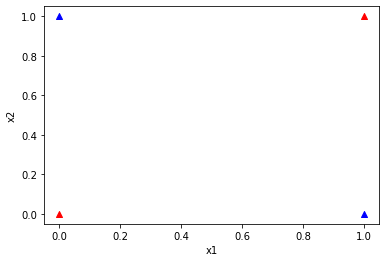

In [2]:
x_data = [[0, 0],
         [0, 1],
         [1, 0],
         [1, 1]]
y_data = [[0],
         [1],
         [1],
         [0]]
plt.scatter(x_data[0][0], x_data[0][1], c='red', marker='^')
plt.scatter(x_data[3][0], x_data[3][1], c='red', marker='^')
plt.scatter(x_data[1][0], x_data[1][1], c='blue', marker='^')
plt.scatter(x_data[2][0], x_data[2][1], c='blue', marker='^')

plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

## Tensorflow Eager
- Tensorlow Data API를 이용해 dataset에 학습 시킬 값을 담는다.
- preprocess function으로 Data type을 맞춘다.

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data)).batch(len(x_data))

def preprocess_data(features, labels):
    features = tf.cast(features, tf.float32)
    labels = tf.cast(labels, tf.float32)
    return features, labels

## Logistic Regression
- W, b는 0이나 random 값으로 초기화
- Sigmoid 함수로 가설 선언
- 가설 검증할 Cost Function(또는 Loss Function) 선언
- GradientTape으로 경사값 계산

In [4]:
W = tf.Variable(tf.zeros((2,1)), name='weight')
b = tf.Variable(tf.zeros((1,)), name='bias')
print("W = {}, b = {}".format(W.numpy(), b.numpy()))

W = [[0.]
 [0.]], b = [0.]


In [5]:
def logistic_regression(features):
    hypothesis  = tf.divide(1., 1. + tf.exp(tf.matmul(features, W) + b))
    return hypothesis

In [6]:
def loss_fn(hypothesis, features, labels):
    cost = -tf.reduce_mean(labels * tf.math.log(logistic_regression(features)) + (1 - labels) * tf.math.log(1 - hypothesis))
    return cost

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [7]:
def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

In [8]:
def grad(features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(logistic_regression(features), features, labels)
        return tape.gradient(loss_value, [W, b])

## 학습
- 학습 시킨 후 모델 생성

In [9]:
EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels in dataset:
        features, labels = preprocess_data(features, labels)
        grads = grad(features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads, [W, b]))
        if step % 100 == 0:
            print('Iter: {}, Loss: {:.4f}'.format(step, loss_fn(logistic_regression(features), features, labels)))
print('W = {}, b= {}'.format(W.numpy(), b.numpy()))
x_data, y_data = preprocess_data(x_data, y_data)
test_acc = accuracy_fn(logistic_regression(x_data), y_data)
print("Test Accuracy: {:.4f}".format(test_acc))

Iter: 0, Loss: 0.6931
Iter: 100, Loss: 0.6931
Iter: 200, Loss: 0.6931
Iter: 300, Loss: 0.6931
Iter: 400, Loss: 0.6931
Iter: 500, Loss: 0.6931
Iter: 600, Loss: 0.6931
Iter: 700, Loss: 0.6931
Iter: 800, Loss: 0.6931
Iter: 900, Loss: 0.6931
Iter: 1000, Loss: 0.6931
W = [[0.]
 [0.]], b= [0.]
Test Accuracy: 0.5000


- 위와 같이 Linear Regression만으로는 XOR 데이터를 학습시킬 수 없다.
- Test Accuracy를 50%에서 더 올릴 방법이 없기 때문
- 따라서, Neural Net을 구성하여 XOR 데이터를 학습하는 모델을 만들어야 한다.

## Neural Net 구성
- 3 Layer Nerual Network를 구성하여 모델을 생성

In [10]:
W1 = tf.Variable(tf.random.normal([2, 1]), name='weight1')
b1 = tf.Variable(tf.random.normal([1,]), name='bias1')

W2 = tf.Variable(tf.random.normal([2, 1]), name='weight2')
b2 = tf.Variable(tf.random.normal([1,]), name='bias2')

W3 = tf.Variable(tf.random.normal([2, 1]), name='weight3')
b3 = tf.Variable(tf.random.normal([1,]), name='bias3')

In [11]:
def neural_net(features):
    layer1 = tf.sigmoid(tf.matmul(features, W1) + b1)
    layer2 = tf.sigmoid(tf.matmul(features, W2) + b2)
    layer3 = tf.concat([layer1, layer2], -1)
    layer3 = tf.reshape(layer3, shape = [-1, 2])
    hypothesis = tf.sigmoid(tf.matmul(layer3, W3) + b3)
    return hypothesis

In [12]:
def loss_fn(hypothesis, labels):
    cost = -tf.reduce_mean(labels * tf.math.log(hypothesis) + (1 - labels) * tf.math.log(1 - hypothesis))
    return cost

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
    return accuracy

def grad_nn(features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(neural_net(features), labels)
    return tape.gradient(loss_value, [W1, W2, W3, b1, b2, b3])

### Neural Network 학습

In [13]:
EPOCHS = 50000

for step in range(EPOCHS):
    for features, labels in dataset:
        features, labels = preprocess_data(features, labels)
        grads = grad_nn(features, labels)
        optimizer.apply_gradients(grads_and_vars=zip(grads, [W1, W2, W3, b1, b2, b3]))
        if step % 5000 == 0:
            print('Iter: {}, Loss:{:.4f}'.format(step, loss_fn(neural_net(features), labels)))
x_data, y_data = preprocess_data(x_data, y_data)
test_acc = accuracy_fn(neural_net(x_data), y_data)
print('Test Accuracy: {:.4f}'.format(test_acc))

Iter: 0, Loss:0.8487
Iter: 5000, Loss:0.6847
Iter: 10000, Loss:0.6610
Iter: 15000, Loss:0.6154
Iter: 20000, Loss:0.5722
Iter: 25000, Loss:0.5433
Iter: 30000, Loss:0.5211
Iter: 35000, Loss:0.4911
Iter: 40000, Loss:0.4416
Iter: 45000, Loss:0.3313
Test Accuracy: 1.0000


## Class를 이용하여 Neural Net 구성하기
- Neural Net 클래스를 만들어 모델링
- 위에서 설정한 weights / bias 값과 구현한 function을 하나의 NN class로 만든다.(재사용성을 위해)

In [19]:
# dataset은 3번째 cell에서 선언했으므로 생략
nb_classes = 10

class wide_deep_nn():
    def __init__(self, nb_classes):
        super(wide_deep_nn, self).__init__()        
     
        self.W1 = tf.Variable(tf.random.normal((2, nb_classes)), name='weight1')
        self.b1 = tf.Variable(tf.random.normal((nb_classes,)), name='bias1')

        self.W2 = tf.Variable(tf.random.normal((nb_classes, nb_classes)), name='weight2')
        self.b2 = tf.Variable(tf.random.normal((nb_classes,)), name='bias2')

        self.W3 = tf.Variable(tf.random.normal((nb_classes, nb_classes)), name='weight3')
        self.b3 = tf.Variable(tf.random.normal((nb_classes,)), name='bias3')

        self.W4 = tf.Variable(tf.random.normal((nb_classes, 1)), name='weight4')
        self.b4 = tf.Variable(tf.random.normal((1,)), name='bias4')
        
        self.variables = [self.W1,self.b1,self.W2,self.b2,self.W3,self.b3,self.W4,self.b4]
        
    def preprocess_data(self, features, labels):
        features = tf.cast(features, tf.float32)
        labels = tf.cast(labels, tf.float32)
        return features, labels
        
    def deep_nn(self, features):
        layer1 = tf.sigmoid(tf.matmul(features, self.W1) + self.b1)
        layer2 = tf.sigmoid(tf.matmul(layer1, self.W2) + self.b2)
        layer3 = tf.sigmoid(tf.matmul(layer2, self.W3) + self.b3)
        hypothesis = tf.sigmoid(tf.matmul(layer3, self.W4) + self.b4)
        return hypothesis

    def loss_fn(self, hypothesis, features, labels):
        cost = -tf.reduce_mean(labels * tf.math.log(hypothesis) + (1 - labels) * tf.math.log(1 - hypothesis))
        return cost
    
    
    def accuracy_fn(self, hypothesis, labels):
        predicted = tf.cast(hypothesis > 0.5, dtype=tf.float32)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype=tf.float32))
        return accuracy


    def grad(self, features, labels):
        with tf.GradientTape() as tape:
            loss_value = self.loss_fn(self.deep_nn(features),features,labels)
        return tape.gradient(loss_value,self.variables)

    def fit(self, dataset, EPOCHS=20000, verbose=500):
        optimizer =  tf.keras.optimizers.SGD(learning_rate=0.01)
        for step in range(EPOCHS):
            for features, labels  in dataset:
                features, labels = self.preprocess_data(features, labels)
                grads = self.grad(features, labels)
                optimizer.apply_gradients(grads_and_vars=zip(grads, self.variables))
                if step % verbose == 0:
                    print("Iter: {}, Loss: {:.4f}".format(step, self.loss_fn(self.deep_nn(features),features,labels)))

    def test_model(self,x_data, y_data):
        x_data, y_data = self.preprocess_data(x_data, y_data)
        test_acc = self.accuracy_fn(self.deep_nn(x_data),y_data)
        print("Testset Accuracy: {:.4f}".format(test_acc))

In [ ]:
model = wide_deep_nn(nb_classes)
model.fit(dataset)

Iter: 0, Loss: 1.2497
Iter: 500, Loss: 0.6848
Iter: 1000, Loss: 0.6823
Iter: 1500, Loss: 0.6794
Iter: 2000, Loss: 0.6761
Iter: 2500, Loss: 0.6722
Iter: 3000, Loss: 0.6676
Iter: 3500, Loss: 0.6622
Iter: 4000, Loss: 0.6558
Iter: 4500, Loss: 0.6483
Iter: 5000, Loss: 0.6398
Iter: 5500, Loss: 0.6300
Iter: 6000, Loss: 0.6188
Iter: 6500, Loss: 0.6055
Iter: 7000, Loss: 0.5898
Iter: 7500, Loss: 0.5708
Iter: 8000, Loss: 0.5477
Iter: 8500, Loss: 0.5198
Iter: 9000, Loss: 0.4863
Iter: 9500, Loss: 0.4469
Iter: 10000, Loss: 0.4024
Iter: 10500, Loss: 0.3544
Iter: 11000, Loss: 0.3057
Iter: 11500, Loss: 0.2592
Iter: 12000, Loss: 0.2175
Iter: 12500, Loss: 0.1817
Iter: 13000, Loss: 0.1521
Iter: 13500, Loss: 0.1280
Iter: 14000, Loss: 0.1086
Iter: 14500, Loss: 0.0931
Iter: 15000, Loss: 0.0806
Iter: 15500, Loss: 0.0705
Iter: 16000, Loss: 0.0621
Iter: 16500, Loss: 0.0553
Iter: 17000, Loss: 0.0496
Iter: 17500, Loss: 0.0447
Iter: 18000, Loss: 0.0406
